In [16]:
%tensorflow_version 2.x
import io
import os
import sys
import warnings
from datetime import datetime
import shutil
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cycler
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding
from keras.optimizers import Adam, RMSprop, SGD
from keras.callbacks import ModelCheckpoint
from keras.utils.vis_utils import plot_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorboard.plugins.hparams import api as hp
 
try:
  shutil.rmtree("./sample_data")
except:
  pass

In [2]:
!rm -rf logs/image

log_dir="logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir, histogram_freq=1)
hparams_callback = hp.KerasCallback(log_dir, {
    'num_relu_units': 512,
    'dropout': 0.2
})

In [3]:
with io.open("./drive/MyDrive/moes_tavern_lines.txt", encoding = "utf-8-sig") as f:
  text = f.read().lower()

print("Sample training data :\n")
text = text[81:]
print(text[:500])

Sample training data :

moe_szyslak: (into phone) moe's tavern. where the elite meet to drink.
bart_simpson: eh, yeah, hello, is mike there? last name, rotch.
moe_szyslak: (into phone) hold on, i'll check. (to barflies) mike rotch. mike rotch. hey, has anybody seen mike rotch, lately?
moe_szyslak: (into phone) listen you little puke. one of these days i'm gonna catch you, and i'm gonna carve my name on your back with an ice pick.
moe_szyslak: what's the matter homer? you're not your normal effervescent self.
homer_simp


In [4]:
data = text.split("\n")
print(data[0])
data = " ".join(data)
print(data[:100])

moe_szyslak: (into phone) moe's tavern. where the elite meet to drink.
moe_szyslak: (into phone) moe's tavern. where the elite meet to drink. bart_simpson: eh, yeah, hello


In [6]:
punctuations = {
    '.' : "period", 
    '[' : "leftbraces",
    ']' : "rightbraces",
    '(' : "leftparen",
    ')' : "rightparen",
    ';' : "semicolon",
    '$' : "price",
    '%' : "percentage",
    '&' : "and",
    '#' : "hash",
    '\n' : "newline",
    ':' : "colon", 
    "'" : "apostrophe",
    '/' : "or",
    '"' : "quote",
    ',' : "comma",
    '?' : "question",
    '*' : "asterisk",
    '!' : "exclamation",
    '-' : "hyphen",
}

def preprocess_text(text):
  for punc, alt in punctuations.items():
    text = text.replace(punc, ' ' + alt + ' ')
  text = text.replace("\n", punctuations["\n"])
  tokens = text.split()
  return tokens

tokens = preprocess_text(text)
print(tokens[:101])

['moe_szyslak', 'colon', 'leftparen', 'into', 'phone', 'rightparen', 'moe', 'apostrophe', 's', 'tavern', 'period', 'where', 'the', 'elite', 'meet', 'to', 'drink', 'period', 'newline', 'bart_simpson', 'colon', 'eh', 'comma', 'yeah', 'comma', 'hello', 'comma', 'is', 'mike', 'there', 'question', 'last', 'name', 'comma', 'rotch', 'period', 'newline', 'moe_szyslak', 'colon', 'leftparen', 'into', 'phone', 'rightparen', 'hold', 'on', 'comma', 'i', 'apostrophe', 'll', 'check', 'period', 'leftparen', 'to', 'barflies', 'rightparen', 'mike', 'rotch', 'period', 'mike', 'rotch', 'period', 'hey', 'comma', 'has', 'anybody', 'seen', 'mike', 'rotch', 'comma', 'lately', 'question', 'newline', 'moe_szyslak', 'colon', 'leftparen', 'into', 'phone', 'rightparen', 'listen', 'you', 'little', 'puke', 'period', 'one', 'of', 'these', 'days', 'i', 'apostrophe', 'm', 'gonna', 'catch', 'you', 'comma', 'and', 'i', 'apostrophe', 'm', 'gonna', 'carve', 'my']


In [8]:
print("length of tokens : " + str(len(tokens)))
print("number of unique tokens : " + str(len(set(tokens))))

length of tokens : 79756
number of unique tokens : 6355


In [9]:
sequence_length = 50 + 1
lines = []

for i in range(sequence_length, len(tokens)):
  sequence = tokens[i - sequence_length : i]
  lines.append(' '.join(sequence))

print(len(lines))

79705


In [11]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(lines)
sequences = tokenizer.texts_to_sequences(lines)
sequences = pad_sequences(sequences, maxlen = sequence_length, truncating='pre')
len(sequences[0])

51

In [12]:
sequences = np.array(sequences)
x, y = sequences[:, :-1], sequences[:, -1]
sequence_length = x.shape[1]
sequence_length

50

In [13]:
vocab_size = len(tokenizer.word_index) + 1
y = to_categorical(y, num_classes=vocab_size)
vocab_size

6259

In [14]:
model = Sequential()
model.add(Embedding(vocab_size, 50, input_length=x.shape[1]))
model.add(LSTM(256))
model.add(Dense(128, activation='relu'))
model.add(Dense(vocab_size, activation='softmax'))

model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 50)            312950    
_________________________________________________________________
lstm (LSTM)                  (None, 256)               314368    
_________________________________________________________________
dense (Dense)                (None, 128)               32896     
_________________________________________________________________
dense_1 (Dense)              (None, 6259)              807411    
Total params: 1,467,625
Trainable params: 1,467,625
Non-trainable params: 0
_________________________________________________________________


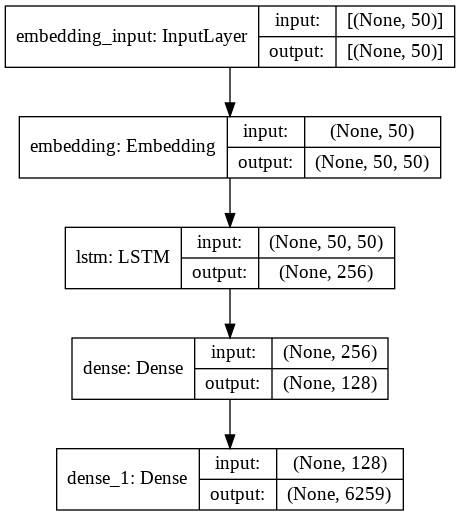

In [17]:
plot_model(model, to_file='script-generation-model-architecture.png', show_shapes=True, show_layer_names=True)

In [15]:
history = model.fit(x, y, epochs = 180, batch_size = 128, callbacks=[tensorboard_callback, hparams_callback])

Epoch 1/180
623/623 [==============================] - 20s 20ms/step - loss: 5.9794 - accuracy: 0.0904
Epoch 2/180
623/623 [==============================] - 12s 20ms/step - loss: 4.8138 - accuracy: 0.2270
Epoch 3/180
623/623 [==============================] - 12s 20ms/step - loss: 4.2893 - accuracy: 0.3107
Epoch 4/180
623/623 [==============================] - 12s 20ms/step - loss: 4.0189 - accuracy: 0.3343
Epoch 5/180
623/623 [==============================] - 12s 20ms/step - loss: 3.8304 - accuracy: 0.3502
Epoch 6/180
623/623 [==============================] - 12s 20ms/step - loss: 3.7208 - accuracy: 0.3558
Epoch 7/180
623/623 [==============================] - 12s 20ms/step - loss: 3.5759 - accuracy: 0.3670
Epoch 8/180
623/623 [==============================] - 12s 20ms/step - loss: 3.4636 - accuracy: 0.3746
Epoch 9/180
623/623 [==============================] - 12s 20ms/step - loss: 3.3350 - accuracy: 0.3828
Epoch 10/180
623/623 [==============================] - 12s 20ms/step - l

In [18]:
!tensorboard dev upload --logdir ./logs \
  --name "Simpsons Script Generation using LSTM architecture  " \
  --description "Training results from https://colab.research.google.com/drive/1RuolxiuHm60Xm9C-X4OtcT5scWTtwFWQ#scrollTo=FJO8Dn0oM25T" \
  --one_shot

2021-01-02 18:24:29.393616: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1

***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./logs

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=373649185512-8v619h5kft38l4456nm2dj4ubeqsrvh6.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&sc

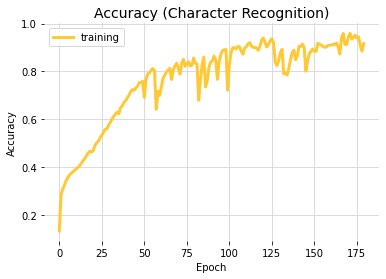

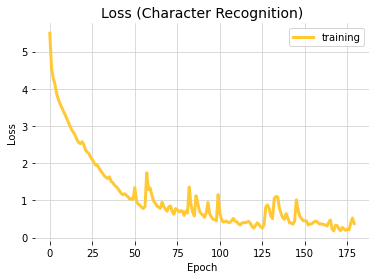

In [ ]:
colors = cycler('color',
              ['#ffc936', '#07a8d9'])
plt.rc('axes', facecolor='#FFFFFF', edgecolor='none',
      axisbelow=True, grid=True, prop_cycle = colors)
plt.rc('grid', color='lightgray', linestyle='solid')
plt.rc('patch', edgecolor='#fafafa')
plt.rc('lines', linewidth=3)

plt.plot(history.history["accuracy"])
plt.title("Accuracy (Character Recognition)", fontsize = "14")
plt.xlabel('Epoch')
plt.ylabel("Accuracy")
plt.legend(['training'])
plt.show()

plt.plot(history.history["loss"])
plt.title("Loss (Character Recognition)", fontsize = "14")
plt.xlabel('Epoch')
plt.ylabel("Loss")
plt.legend(['training'])
plt.show();

In [ ]:
model.save("drive/MyDrive/script-generation-sample/script-generation-model-with-punctuation.h5", save_format='h5')

In [ ]:
model.save_weights("drive/MyDrive/script-generation-sample/script-generation-model-weights-with-punctuation.h5", save_format='h5')

In [ ]:
saved_model = Sequential()
saved_model.add(Embedding(vocab_size, 50, input_length=x.shape[1]))
saved_model.add(LSTM(256))
saved_model.add(Dense(128, activation='relu'))
saved_model.add(Dense(vocab_size, activation='softmax'))
saved_model.load_weights("./drive/MyDrive/script-generation-sample/script-generation-model-weights-with-punctuation.h5")

saved_model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
saved_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 50)            312950    
_________________________________________________________________
lstm (LSTM)                  (None, 256)               314368    
_________________________________________________________________
dense (Dense)                (None, 128)               32896     
_________________________________________________________________
dense_1 (Dense)              (None, 6259)              807411    
Total params: 1,467,625
Trainable params: 1,467,625
Non-trainable params: 0
_________________________________________________________________


In [ ]:
saved_model = tf.keras.models.load_model("drive/MyDrive/script-generation-sample/script-generation-model-with-punctuation.h5")
saved_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 50)            312950    
_________________________________________________________________
lstm (LSTM)                  (None, 256)               314368    
_________________________________________________________________
dense (Dense)                (None, 128)               32896     
_________________________________________________________________
dense_1 (Dense)              (None, 6259)              807411    
Total params: 1,467,625
Trainable params: 1,467,625
Non-trainable params: 0
_________________________________________________________________


In [ ]:
def generate_text_seq(model, tokenizer, text_seq_length, seed_text, n_words):
  sys.stdout.write(seed_text + "\n");
  text = []
  for _ in range(n_words):
    encoded = tokenizer.texts_to_sequences([seed_text])[0]
    encoded = pad_sequences([encoded], maxlen = text_seq_length, truncating='pre')
    y_predict = model.predict_classes(encoded)

    predicted_word = ''
    for word, index in tokenizer.word_index.items():
      if index == y_predict:
        predicted_word = word
        break
    seed_text = seed_text + ' ' + predicted_word

    if predicted_word in list(punctuations.values()):
      predicted_word = list(punctuations.keys())[list(punctuations.values()).index(predicted_word)]

    text.append(predicted_word)
  return ' '.join(text)

In [ ]:
warnings.filterwarnings("ignore") 
test_text = "marge well leave it to good old Mary Bailey to finally step in and do something about that hideous genetic mutation homer mary bailey well if i was governor i d sure find better things to do with my time marge like what homer like getting"
print(generate_text_seq(saved_model, tokenizer, sequence_length, test_text, 100))
# print(generate_text_seq(saved_model, tokenizer, sequence_length, " ".join(tokens[120:170]), 100))

marge well leave it to good old Mary Bailey to finally step in and do something about that hideous genetic mutation homer mary bailey well if i was governor i d sure find better things to do with my time marge like what homer like getting
disappointed to say by my mother , buy ran his alley . 
 lenny leonard : keep everyone here real optimistic literature celebrities ? ( cute ) oh , as it ' s so strong at us out from now . i don ' t think it ' s given me a beer . 
 
 
 larry : oh , duff lovers ! does anyone in the only dangerous brunch spectacular . 
 
 
 smitty : you know that , ain ' t that smile . 
 
 
 mrs . powers : ( suddenly nervous ) you
